# Sprint 機械学習スクラッチ クラスタリング

In [42]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# 評価
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
# 可視化
import matplotlib.pyplot as plt
import japanize_matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [43]:
# 人口データセットの作成
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

In [44]:
# サンプル数
m = X.shape[0]
# 特徴量の数
n = X.shape[1]
print('サンプル数:{0}\n特徴量の数:{1}'.format(m,n))

サンプル数:100
特徴量の数:2


In [45]:
# 正解ラベル
print('クラスラベル：',np.unique(_, return_counts=True))

クラスラベル： (array([0, 1, 2, 3]), array([25, 25, 25, 25], dtype=int64))


# 【問題1】中心点の初期値を決める
* 入力されたデータからK個の中心点μ1からμKの初期値を決めるコードを作成．
* Kは指定したクラスタ数．

* 最もシンプルな初期値の決定方法は、データ点Xnの中からランダムにK個選ぶこと(今回はこれも実装)

* K-meansの学習結果は中心点μの初期値に影響を受ける．そのため、学習時には複数個の初期値で計算を行う．

In [46]:
# シードの固定
random.seed(0)
K = 4

# 中心点を入れる空のarray
centroids = np.array([]).reshape(0,n)
for i in range(K):
    rand = random.randint(0,len(X)-1)
    print(rand)
    centroids = np.vstack((centroids,X[rand]))
centroids

49
97
53
5


array([[ 0.5323772 ,  3.31338909],
       [-1.56102482,  3.77455362],
       [-1.74448079,  3.84251413],
       [ 0.78260667,  4.15263595]])

# 【問題2】SSEを求める関数の作成
* クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数の作成．
* K-meansはこのSSEを最小化するrnkとμkを求めることが目的
* 数個の初期値で計算したクラスタリング結果から、どれを最終的に採用するかを決める際にこのSSEを求める関数を使用する
* メモ：アルゴリズムの出力は、キーとしてクラスター番号を持ち、値としてそのクラスターに属するデータポイントを持つ辞書でなければならない．らしい．

In [47]:
def SSE(X=X,centroids=centroids,K=K):
    # セントロイドとの距離を入れるarray
    distance = np.array([]).reshape(X.shape[0],0)
    for k in range(K):
        tempDist = np.sum((X-centroids[k,:])**2,axis=1)
        #print(tempDist)
        #print(tempDist.shape)
        distance = np.column_stack([distance,tempDist])
        #print(distance.shape)   
    #print(distance)
    C = np.argmin(distance,axis=1)
    
    min_distance = np.zeros(len(X))
    for num in range(len(X)):
        # 一番小さい距離の値を足す．
        min_distance[num] =  distance[num,C[num]]
        sse = np.sum(min_distance)
    return sse

In [48]:
SSE(X,centroids,K)

629.071999954795

# 【問題3】クラスタへの割り当て
* 全てのデータ点Xnを最も近い中心点μkに割り当てるコードを作成
* K-menasにおける「近い」とは，点と点のユークリッド距離が小さくなること
* ユークリッド距離とはピタゴラスの定理（三平方の定理）で求められる

In [49]:
def _cluster(X,K,centroids):
    norm_list = np.array([]).reshape(0,K)
    for i in range(len(X)):
        N = np.linalg.norm(X[i] - centroids, ord=2, axis=1)
        norm_list = np.vstack((norm_list,N))
    cluster = np.argmin(norm_list,axis=1)
    return cluster

In [50]:
_cluster(X,K,centroids)

array([0, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 0, 0, 0, 1, 0, 3, 2,
       2, 0, 3, 1, 1, 3, 0, 0, 0, 2, 0, 0, 1, 3, 2, 0, 3, 1, 3, 1, 2, 2,
       1, 2, 0, 1, 3, 0, 3, 0, 1, 2, 1, 2, 3, 0, 0, 3, 2, 0, 0, 3, 0, 3,
       2, 1, 0, 3, 2, 0, 3, 2, 3, 3, 1, 1, 0, 0, 0, 2, 1, 3, 0, 1, 0, 0,
       3, 3, 3, 1, 0, 1, 2, 2, 2, 1, 3, 3], dtype=int64)

# 【問題4】中心点の移動
* 中心点μkをk番目のクラスタに割り当てられる全てのデータ点Xnの平均値（重心）に移動するコードを作成
* クラスタの割り当てrnkを固定した上でSSEを最小化していることになるが，SSE自体を求める必要はない．

In [51]:
K = 4
new_centroids = np.array([]).reshape(0,2)
for k in range(K):
    new = np.mean(X[_cluster(X,K,centroids)==k],axis=0)
    new_centroids = np.vstack((new_centroids,new))
new_centroids

array([[ 1.76436664,  1.3155527 ],
       [-1.3663346 ,  3.0186171 ],
       [-1.62477588,  6.58360811],
       [ 0.57505158,  5.30311294]])

# 【問題5】繰り返し
* クラスタへの割り当てと中心点の移動を繰り返すことで学習を行うコードを作成
* 次のどれかの条件を満たしたらこれを止める

* 繰り返しが指定した回数に到達する．（雛形では引数max_iter）
* 中心点μkと重心の差が指定した許容値以下になる。（雛形では引数tol）

# 【問題6】異なる初期値で計算
* 問題5の繰り返しを、指定した回数初期値を変更して計算するコードを作成
* 回数は雛形では引数n_initで指定
* 複数計算した中でSSEが最小になったものが最終的な学習結果となるため、その時の中心点μkを保持しておく

# 【問題7】推定
* 新たなデータに対してどのクラスタに所属するかの推定の際は、学習時の1つ目のフェーズと同じことを行う
* データ点Xnと学習で決まった中心点μkに対し，SSEを最小化するrnkを選ぶ．
* データ点Xnを最も近いμkに割り当てる

In [52]:
class ScratchKMeans():
    """
    K-meansのスクラッチ実装

    Parameters
    ----------
    n_clusters : int
      クラスタ数
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    verbose : bool
      学習過程を出力する場合はTrue
    """

    def __init__(self, n_clusters, n_init, max_iter, tol, verbose=False):
        # ハイパーパラメータを属性として記録
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def fit(self, X):
        """
        K-meansによるクラスタリングを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        """

        new_sse = 0
        
        # n_initの回数中心点の初期値を変える
        for a in range(self.n_init):
            # 中心点の初期値
            centroids = X[np.random.choice(X.shape[0],self.n_clusters,replace=False)]
            # 移動前の中心点を入れるarray
            old_centroids = centroids.copy()
            
            # nax_iterの回数，重心を移動
            for i in range(self.max_iter):
                # セントロイドとの距離を求めて，クラスタを決める
                norm_list = np.array([]).reshape(0,self.n_clusters)
                for n in range(len(X)):
                    N = np.linalg.norm(X[n] - centroids, ord=2, axis=1)
                    norm_list = np.vstack((norm_list,N))
                # クラスタに割り当て
                cluster = np.argmin(norm_list,axis=1)
               
                # 新しい重心へ移動
                for k in range(self.n_clusters):
                    centroids[k] = np.mean(X[np.where(cluster==k)], axis=0)
                # 中心点の差がtol以下になったら学習終了
                if np.linalg.norm(centroids - old_centroids) <= self.tol:
                    break
                else:
                    #print('中心点と受信の差',np.linalg.norm(centroids - old_centroids))
                    #print('old_centroids:\n',old_centroids,'\n')
                    old_centroids = centroids.copy()
            
            # SSEを求める
            sse = self.SSE(X,centroids)

            #初回のSSE算出の時は
            if new_sse == 0:
                new_sse = sse
            #ここまでの一番小さいsse以下だった場合、中心点とクラスターを保存しておく．
            if sse <= new_sse:
                self.centroids = centroids.copy()
                #print('best_centroids',self.centroids)
                self.cluster = cluster.copy()
                #print('best_cluster',self.cluster)
                new_sse = sse
                #print(new_sse)
            
            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print('{0}init SSE:\n{1}'.format(a,sse))
            else:
                pass
            
    
    def SSE(self,X,centroids):
        """
        クラスタ内誤差平方和（SSE, Sum of Squared Errors）を計算する関数
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        centrois : 次の形のndarray, shape(n_clusters,X.shape[1])
        return
        ----------
        sse : スカラー
        """

        # セントロイドとXとの差の二乗したものを入れるarray
        distance_array = np.array([]).reshape(X.shape[0],0)
        # 各クラスタとサンプルとの誤差の2乗の総和を計算する
        for k in range(self.n_clusters):
            d = np.sum((X-centroids[k,:])**2,axis=1)
            distance_array = np.column_stack([distance_array,d])
        # 最も誤差が小さかったクラスタに割り当て
        C = np.argmin(distance_array,axis=1)
        
        # 割り当てられたクラスタでSSEを求める
        min_distance = np.zeros(len(X))
        for num in range(len(X)):
            min_distance[num] =  distance_array[num,C[num]]
            sse = np.sum(min_distance)
        return sse
    

    def predict(self, X):
        """
        入力されたデータがどのクラスタに属するかを計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
            
        return
        ----------
        C : 次の形のndarray, shape (n_samples,)
        """
        distance_array = np.array([]).reshape(X.shape[0],0)
        for k in range(self.n_clusters):
            tempdist=np.sum((X-self.centroids[k,:])**2,axis=1)
            distance_array = np.column_stack([distance_array,tempdist])
        C = np.argmin(distance_array,axis=1)
        return C

In [53]:
# 初期化，学習，推定
skm = ScratchKMeans(n_clusters=4, n_init=10, max_iter=10, tol=1e-4, verbose=True)
skm.fit(X)
y_pred = skm.predict(X)

0init SSE:
134.3167746020285
1init SSE:
134.95838630944522
2init SSE:
134.85438853708433
3init SSE:
48.63378320706403
4init SSE:
48.63378320706403
5init SSE:
132.22875558038203
6init SSE:
48.63378320706403
7init SSE:
48.63378320706403
8init SSE:
48.63378320706403
9init SSE:
48.63378320706403


# 【問題8】エルボー法の実装
* K-meansにおいて中心点の個数kは人為的に決める必要があるが，その判断方法としてエルボー法がある．
* エルボー法により中心点の個数kを検討するためのコードを作成
* SSEを縦軸、クラスタ数kを横軸にした折れ線グラフを表示
* このためにK-meansのインスタンスからはSSEを取得できるようにすること

Text(0, 0.5, 'SSE')

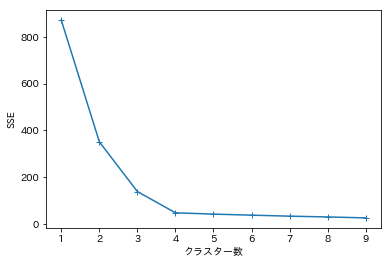

In [54]:
# SSEを入れる空のリスト
sse_list = []

# クラスター数を１～10まで試してみる
for i in range(1,10):
    skm = ScratchKMeans(n_clusters=i, n_init=10, max_iter=10, tol=1e-4, verbose=False)
    skm.fit(X)
    sse = skm.SSE(X,skm.centroids)
    sse_list.append(sse)
    
# ｘ軸は１～10のクラスタ、ｙ軸はSSE
plt.plot(range(1,10),sse_list,marker='+')
plt.xlabel('クラスター数')
plt.ylabel('SSE')

# クラスタ分析

In [55]:
# データの読み込み
Wholesale = pd.read_csv('C:/Users/miyas/dive/diveintocode-ml/Wholesale customers data.csv')
Wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [56]:
# カラム名
Wholesale.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [57]:
# 使用データのみを対数変換
data = Wholesale.drop(['Channel','Region'],axis=1)
data_log = np.log(data).values
data_log

array([[ 9.44691334,  9.17533476,  8.93075874,  5.36597602,  7.89133076,
         7.19893124],
       [ 8.86177531,  9.19115755,  9.16617948,  7.47420481,  8.09955428,
         7.48211892],
       [ 8.75668242,  9.08341568,  8.94689552,  7.78530518,  8.16507926,
         8.96750419],
       ...,
       [ 9.58403958,  9.64782081, 10.31702003,  6.0799332 ,  9.6051489 ,
         7.53208814],
       [ 9.23892783,  7.59135705,  7.71065332,  6.94505106,  5.12396398,
         7.66152708],
       [ 7.93272103,  7.43720637,  7.82803803,  4.17438727,  6.16751649,
         3.95124372]])

In [58]:
# 次元削減
print('次元削減前',data_log.shape)
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(data_log)
data_pca = pca.transform(data_log)
print('次元削減後：',data_pca.shape)

次元削減前 (440, 6)
次元削減後： (440, 2)


[0.44237417 0.71894523 0.83511865 0.93129585 0.97705265 1.        ]


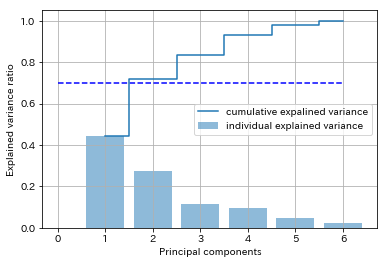

In [59]:
# PCAの分散説明率を表示
pca = PCA(n_components=None)
pca = pca.fit(data_log)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

# 【問題10】クラスタ数kの選択
* 最適だと思われるクラスタ数kを選択
* エルボー法やシルエット図を活用する他、人間が後々どう利用したいのかも選択に関わってくる
* 選択した上で、なぜそれを選んだか説明する

Text(0, 0.5, 'SSE')

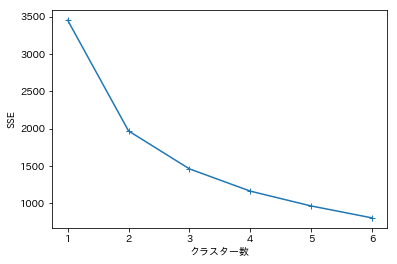

In [60]:
# SSEを入れる箱
sse_list = []

# クラスター数を１～７まで試してみる
for i in range(1,7):
    skm = ScratchKMeans(n_clusters=i, n_init=10, max_iter=10, tol=1e-4, verbose=False)
    skm.fit(data_pca)
    sse = skm.SSE(data_pca,skm.centroids)
    sse_list.append(sse)
    

# ｘ軸は１～７、ｙ軸にはSSE
plt.plot(range(1,7),sse_list,marker='+')
plt.xlabel('クラスター数')
plt.ylabel('SSE')

### エルボー法より，クラスター数Ｋは２とする．

# 【問題11】既知のグループとの比較
* RegionとChannelはK-meansに使用しなかったが、これれらは既知のグループ
* クラスタとこれら既知のグループがどう違うかを確認し、説明
* まずはそれぞれを可視化

In [61]:
# 初期化，学習，推定
skm = ScratchKMeans(n_clusters=2, n_init=10, max_iter=300, tol=1e-4, verbose=False)
skm.fit(data_pca)
y_pred = skm.predict(data_pca)
print(np.unique(y_pred,return_counts=True))

(array([0, 1], dtype=int64), array([262, 178], dtype=int64))


### クラスター０は178人，クラスター１は262人

In [62]:
# dfにクラスターを追加
Wholesale['cluster'] = y_pred
Wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,2,3,12669,9656,7561,214,2674,1338,1
1,2,3,7057,9810,9568,1762,3293,1776,1
2,2,3,6353,8808,7684,2405,3516,7844,1
3,1,3,13265,1196,4221,6404,507,1788,0
4,2,3,22615,5410,7198,3915,1777,5185,1


In [63]:
# 各クラスターの人数
Wholesale.pivot_table('Channel',columns='cluster',aggfunc=np.sum)

cluster,0,1
Channel,268,314


Text(0.5, 1.0, 'クラスター０')

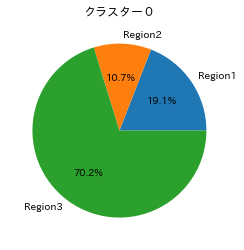

In [64]:
# クラスター当たりのRegionの人数
c0 = Wholesale.groupby(['cluster','Region']).count()['Channel'].iloc[:3]
c1 = Wholesale.groupby(['cluster','Region']).count()['Channel'].iloc[3:]
R_label = ['Region1','Region2','Region3']
plt.pie(c0,labels=R_label,autopct='%1.1f%%')
plt.title('クラスター０')

Text(0.5, 1.0, 'クラスター1')

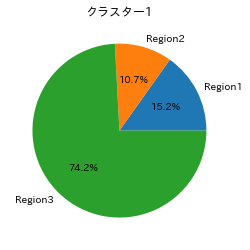

In [65]:
R_label = ['Region1','Region2','Region3']
plt.pie(c1,labels=R_label,autopct='%1.1f%%')
plt.title('クラスター1')

### クラスターごとのRegionの人数分布はあまり変わらない

In [66]:
# 既知のデータと組み合わせて比較
Wholesale_mean = Wholesale.groupby(['Channel','cluster','Region']).mean().round()
Wholesale_mean

Fresh     Milk  Grocery   Frozen  Detergents_Paper  \
Channel cluster Region                                                         
1       0       1       14753.0   2681.0   3145.0   3256.0             539.0   
                2       12038.0   2275.0   4332.0   5922.0             470.0   
                3       14430.0   3123.0   3095.0   3965.0             448.0   
        1       1        4826.0   9058.0   7873.0   2565.0            2747.0   
                2        1182.0   3088.0   6114.0    978.0             821.0   
                3       10551.0   5681.0   8661.0   1796.0            2832.0   
2       0       1        6931.0   4258.0   5440.0   6966.0             872.0   
                2       16823.0    928.0   2743.0  11559.0             332.0   
                3       24241.0   3467.0   6064.0   3639.0             612.0   
        1       1        4984.0  11600.0  20101.0   2036.0            9144.0   
                2        6760.0   9650.0  17081.0    984.0            8859.0   
                3        9408.0  11202.0  16245.0   1451.0            7084.0   

                        Delicassen  
Channel cluster Region              
1       0       1           1115.0  
                2           1086.0  
                3           1448.0  
        1       1           1556.0  
                2           1637.0  
                3           1940.0  
2       0       1           1748.0  
                2           3486.0  
                3           1127.0  
        1       1           1887.0  
                2           1114.0  
                3           1847.0

In [67]:
Wholesale_mean.max()

Fresh               24241.0
Milk                11600.0
Grocery             20101.0
Frozen              11559.0
Detergents_Paper     9144.0
Delicassen           3486.0
dtype: float64

* Freshはcluster１の中のChannel２の中のRegion３の人たちが一番買ってる
* Milkはcluster0の中の，Channel2の中の，Region1の人たちがが一番買ってる
* Groceryは，cluster0の中の，Channel2の中の，Region1の人たちがが一番買ってる
* Frozenは，cluster１の中の，Channel2の中の，Region1の人たちがが一番買ってる
* Detergents_Papeは，cluster０の中の，Channel2の中の，Region1の人たちがが一番買ってる
* Delicassenは，cluster１の中の，Channel2の中の，Region２の人たちがが一番買ってる

# 【問題12】卸売業者にとって有益な情報

In [68]:
# Channel,Regionを抜いたデータにclusterを追加する
data['cluster'] = y_pred
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,cluster
0,12669,9656,7561,214,2674,1338,1
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,1


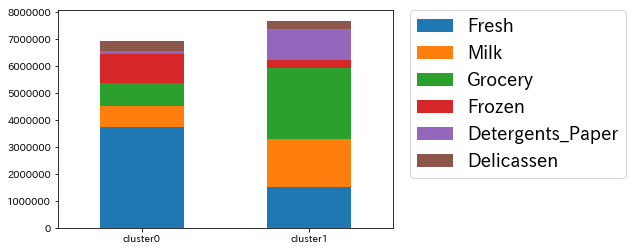

In [69]:
# 可視化（積み上げ棒グラフ）
clusterinfo = pd.DataFrame()
for i in range(2):
    clusterinfo['cluster' + str(i)] = data[data['cluster'] == i].sum()
clusterinfo = clusterinfo.drop('cluster')
 
my_plot = clusterinfo.T.plot(kind='bar', stacked=True)
my_plot.set_xticklabels(my_plot.xaxis.get_majorticklabels(), rotation=0)
#plt.legend(bbox_to_anchor=(1,0))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

* メモ：plt.legend(bbox_to_anchor=(1,0))で，凡例の位置を色々いじれる
* クラスター０の方が，人数が多い分，売り上げも若干高い．（が大差ない．）
* クラスター０は，乾物をよく買うグループ
* クラスター１は，生鮮食品をよく買うグループ